In [1]:
import numpy as np
import pandas as pd
from mne import create_info
from mne.io import RawArray
import matplotlib.pyplot as plt
from mne.channels.montage import make_standard_montage
from mne.preprocessing import ICA
import mne

In [2]:

path='C:/Users/tomas/Desktop/Mne/ntx_hack_2023/Datasets/initialData.csv'

Creating RawArray with float64 data, n_channels=8, n_times=23690
    Range : 0 ... 23689 =      0.000 ...    94.756 secs
Ready.
[    0     1     2 ... 23687 23688 23689] [1. 1. 1. ... 1. 1. 1.]
stim_data =  [[1. 1. 1. ... 1. 1. 1.]]
Creating RawArray with float64 data, n_channels=1, n_times=23690
    Range : 0 ... 23689 =      0.000 ...    94.756 secs
Ready.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


C:\Users\tomas\AppData\Local\Temp\ipykernel_12076\2111494408.py:37: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(thisRec)


Fitting ICA took 0.3s.


C:\Users\tomas\AppData\Local\Temp\ipykernel_12076\2111494408.py:37: RuntimeWarning: Using n_components=8 (resulting in n_components_=8) may lead to an unstable mixing matrix estimation because the ratio between the largest (2.2) and smallest (2.1e-11) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 1
  ica.fit(thisRec)


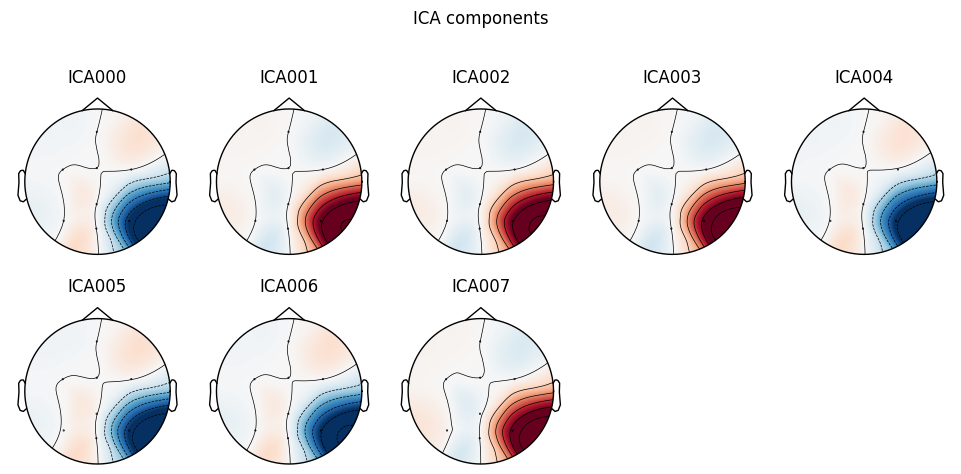

Enter space-separated indices of components to exclude (e.g., 1 3 5), or press Enter to skip: 


Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Using matplotlib as 2D backend.


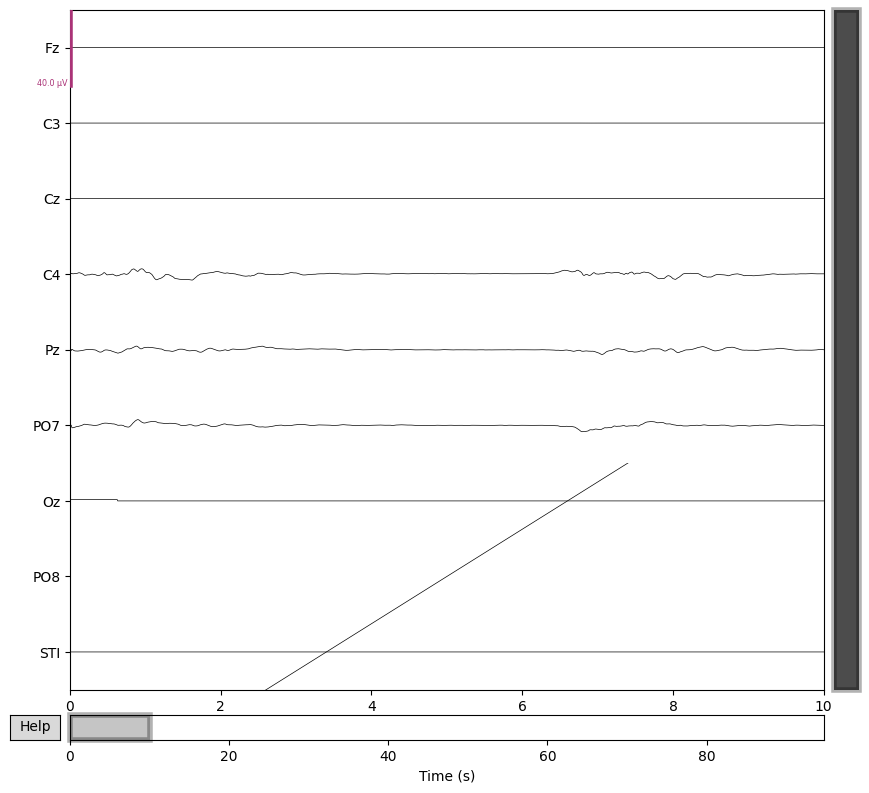

In [3]:
chs = ["Fz", "C3", "Cz", "C4", "Pz", "PO7", "Oz", "PO8"]
df = pd.read_csv(path, names=chs + ["STIM"]) #use STIM only if you have a trigger
trigger = np.array(df.STIM)
eeg = df.iloc[:, 0:8].to_numpy()
fs = 250

amplify = 1e6 # amplification factor 
recompute = False # wether if changing trigger numerical values or not to avoid Event "0"

thisRec = RawArray(eeg.T/amplify, create_info(chs, fs, ch_types='eeg'))

# # Get event indexes where value is not 0, i.e. -1 or 1
pos = np.nonzero(trigger)[0]

# Filter 0 values from the trigger array
y = trigger[trigger != 0]
print(pos, y)

# Create the stimuli channel
stim_data = np.zeros((1,thisRec.n_times))

# MNE works with absolute values of labels so -1 and +1 would result in only one kind of event
# that's why we add 2 and obtain 1 and 3 as label values
stim_data[0,pos] = (y + 2) if recompute else  y

print('stim_data = ', stim_data)
stim_raw = RawArray(stim_data, create_info(['STI'], thisRec.info['sfreq'], ch_types=['stim']))

# adding the stimuli channel (as a Raw object) to our EEG Raw object
thisRec.add_channels([stim_raw])

# Set the standard 10-20 montage
montage = make_standard_montage('standard_1020')
thisRec.set_montage(montage)
# Apply ICA for artifact removal
ica = ICA(n_components=8, random_state=97, max_iter=800)
ica.fit(thisRec)

# Plot ICA components for manual inspection
ica.plot_components()

# Wait for user input to identify components to exclude (e.g., artifacts)
exclude = []
user_input = input("Enter space-separated indices of components to exclude (e.g., 1 3 5), or press Enter to skip:")
if user_input:
    exclude = list(map(int, user_input.split()))
    
# Exclude selected components
ica.exclude = exclude
thisRec = ica.apply(thisRec)

# Plot with adjusted scale (e.g., 1e-4 for EEG channels)
thisRec.plot()
plt.show()